Add and commit files and push them to github using git python API and access token



<span style="font-size:25px;">Table of Contents</span>

* [Initialization with token, remote repo_url, and repo_path](#0)
* [Choose the files with EXCLUDE_FOLDERS and MAX_FILE_SIZE](#1)
* [Add files](#2)
* [Delete files](#3)
* [Commit and push](#4)



In [ ]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
import torch
import os
import numpy as np
import pickle
import time
from tqdm import tqdm
import datetime

In [2]:
tokenizer = AutoTokenizer.from_pretrained("t5-11b")

/home1/09127/tomyoung/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-11b automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [78]:
model = T5ForConditionalGeneration.from_pretrained("t5-11b", cache_dir='/work/09127/tomyoung/ls6/inconsistencies_project/t5-11b-cache', low_cpu_mem_usage=True, torch_dtype=torch.bfloat16)
model.parallelize()

self.device_map
{0: [0, 1, 2, 3, 4, 5, 6, 7], 1: [8, 9, 10, 11, 12, 13, 14, 15], 2: [16, 17, 18, 19, 20, 21, 22, 23]}


In [79]:
device = torch.device("cuda:0")

In [1]:
activate_print = False

if activate_print:
    # define show as a function that takes any kind of input and does nothing
    def show(*args, **kwargs):
        pass
else:
    show = print

In [22]:
# /work/09127/tomyoung/ls6/glm/GLM-130B/evaluation_data/evaluation/lambada/lambada/please_next_word/gen/test.jsonl
import json
import os
with open("/work/09127/tomyoung/ls6/glm/GLM-130B/evaluation_data/evaluation/lambada/lambada/please_next_word/gen/test.jsonl", "r") as f:
    data = [json.loads(line) for line in f.readlines()]
# append [NLG] to the beginning of each input, and <extra_id_0> to the end
data_appended = [{"inputs_pretokenized": x['inputs_pretokenized'] + " <extra_id_0>", "targets_pretokenized": x['targets_pretokenized']} for x in data]

In [3]:
from string import punctuation as PUNCTUATIONS
PUNCTUATIONS_LIST = list(PUNCTUATIONS)
PUNCTUATIONS_LIST.remove("<")
PUNCTUATIONS_LIST.remove(">")
PUNCTUATIONS_LIST.remove("_")
PUNCTUATION_IDS_LIST = [tokenizer.get_vocab()[p] for p in PUNCTUATIONS_LIST if p in tokenizer.get_vocab()]

In [4]:
# TODO: a bit hacky, add explanations
def get_words_from_options(options):
    '''Get the first word from each of the given options. Return the words.'''
    # if a punctuation can be found in the option, get the word before the punctuation
    words = []
    for option in options:
        # find the punctuation
        for i in range(len(option)):
            if option[i] in PUNCTUATIONS_LIST:
                word = option[:i]
                words.append(word)
                # print(words)
                break

    # if the word starts with <pad>, remove it
    words = [word[5:] if word.startswith("<pad>") else word for word in words]

    # check it it the case that, assert that if the word starts with <extra_id_0>, ' ' follows. print the word if it is not the case
    for word in words:
        if word.startswith("<extra_id_0>") and len(word) > 13:
            if word[12] != " ":
                print('word[12] != \" \"')
                print(word)

    # if the word starts with <extra_id_0>, remove it
    words = [word[12:] if word.startswith("<extra_id_0>") else word for word in words]
    # if the word starts with ' ', remove it
    words = [word[1:] if word.startswith(" ") else word for word in words]
    # if the word ends with ' ', remove it
    words = [word[:-1] if word.endswith(" ") else word for word in words]
    # if the word is empty, remove it
    words = [word for word in words if word != ""]
    # if there are multiple words in word, remove it
    words = [word for word in words if len(word.split(" ")) == 1]
    return words

In [5]:
def get_word_from_option(option):
    '''Get the first word from the given option. Return the word.'''
    found = False
    # if a punctuation can be found in the option, get the word before the punctuation
    for i in range(len(option)):
        if option[i] in PUNCTUATIONS_LIST:
            word = option[:i]
            found = True
            break
    if not found:
        return None

    # if the word starts with <pad>, remove it
    word = word[5:] if word.startswith("<pad>") else word

    # check it it the case that, assert that if the word starts with <extra_id_0>, ' ' follows. print the word if it is not the case
    if word.startswith("<extra_id_0>") and len(word) > 13:
        if word[12] != " ":
            show('word[12] != \" \"')
            show(word)

    # if the word starts with <extra_id_0>, remove it
    word = word[12:] if word.startswith("<extra_id_0>") else word
    # if the word starts with ' ', remove it
    word = word[1:] if word.startswith(" ") else word
    # if the word ends with ' ', remove it
    word = word[:-1] if word.endswith(" ") else word
    # if the word is empty, remove it
    word = word if word != "" else None
    # if there are multiple words in word, remove it
    if word:
        word = word if len(word.split(" ")) == 1 else None
    return word

In [6]:
def get_word_punc_pairs(options):
    '''given a list of options (completions by the LLM), return a list of word-punc pairs'''
    # show(options)
    # if a punctuation can be found in the option, get the word before the punctuation
    words = []
    for option in options:
        # find the punctuation
        for i in range(len(option)):
            if option[i] in PUNCTUATIONS_LIST:
                word = option[:i+1]
                words.append(word)
                # show(words)
                break
    
    # if the word starts with <pad>, remove the <pad>
    words = [word[5:] if word.startswith("<pad>") else word for word in words]
    # if the word starts with <extra_id_0>, remove the <extra_id_0>
    words = [word[12:] if word.startswith("<extra_id_0>") else word for word in words]
    # if the word starts with ' ', remove it
    words = [word[1:] if word.startswith(" ") else word for word in words]
    # if the word ends with ' ', remove it
    words = [word[:-1] if word.endswith(" ") else word for word in words]
    # if the word is empty, remove it
    words = [word for word in words if word != ""]
    # if there are multiple words in word, remove it
    words = [word for word in words if len(word.split(" ")) == 1]
    # if the length is 1, remove it (to prevent the case where it is just a punctuation)
    words = [word for word in words if len(word) > 1]
    # if the word contains <unk>, remove it
    words = [word for word in words if "<unk>" not in word]
    return list(set(words))

In [7]:
def remove_pad(options):
    '''given a list of options (completions by the LLM), remove the <pad>'''
    # if the word starts with <pad>, remove the <pad>
    options = [option[5:] if option.startswith("<pad>") else option for option in options]
    return options

In [8]:
def remove_pad_id(options):
    '''given a list of options of ids (completions by the LLM), remove the <pad>'''
    pad_id = tokenizer.convert_tokens_to_ids("<pad>")
    # if the word starts with <pad>, remove the <pad>
    options_return = []
    for option in options:
        if option[0] == pad_id:
            options_return.append(option[1:])
        else:
            options_return.append(option)
    return options_return

In [9]:
def before_first_punc(options):
    options_return = []
    for option in options:
        for i in range(len(option)):
            if option[i] in PUNCTUATION_IDS_LIST:
                options_return.append(option[:i+1])
                break
    return options_return

In [10]:
from tqdm import tqdm
# cross entroy loss with logits and labels
import torch
import torch.nn as nn
import torch.nn.functional as F
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id) #reduction='sum'
# loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
loss_fn_sum = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction='sum') #reduction='sum'
# loss

In [ ]:
# generate for all examples, and then get the words from the options, and compare the first one with the target
count_correct = 0
count_correct_top_num_beams = 0
count_no_words_found = 0
id_to_word_and_punc_pairs = {}
id_to_word_and_punc_pairs_processed = {}
id_to_options = {}
for example_index in tqdm(range(len(data_appended))): # len(data_appended)
    input_string = data_appended[example_index]['inputs_pretokenized']
    inputs = tokenizer(input_string, return_tensors="pt").input_ids.to(device)
    num_beams = 10
    outputs = model.generate(inputs, 
                             max_length=8,
                             num_beams=num_beams, 
                             num_return_sequences=num_beams, 
                             output_scores=True,
                             eos_token_id=tokenizer.convert_tokens_to_ids('<extra_id_1>'), 
                             return_dict_in_generate=True)
    
    options = [tokenizer.decode(outputs['sequences'][i]) for i in range(num_beams)]
    # for option in options:
    #     print(option)
    # print([tokenizer.batch_decode(outputs['sequences'][i]) for i in range(num_beams)])
    options_ids = [outputs['sequences'][i] for i in range(num_beams) if get_word_from_option(options[i]) is not None]
    words = get_words_from_options(options)
    options_without_pad = remove_pad_id(options_ids)
    options_without_pad_before_punctution = before_first_punc(options_without_pad)
    # print(words)
    if words:
        # print(options)
        # print(words[0], data_appended[example_index]['targets_pretokenized'])
        if words[0] == data_appended[example_index]['targets_pretokenized'][0]:
            count_correct += 1
    else:
        count_no_words_found += 1
        print("no words found")
    word_and_punc_pairs = get_word_punc_pairs(options)
    id_to_word_and_punc_pairs[example_index] = word_and_punc_pairs
    words_unique = list(set(words))
    id_to_word_and_punc_pairs_processed[example_index] = []
    id_to_options[example_index] = options_without_pad_before_punctution
    for word in words_unique:
        found = 0
        # iterate through the word and punc pairs, and find the one that matches the word
        for word_and_punc_pair in word_and_punc_pairs:
            # it is a match if pair = word + punc
            for punc in PUNCTUATIONS_LIST:
                if word_and_punc_pair == word + punc:
                    id_to_word_and_punc_pairs_processed[example_index].append(word_and_punc_pair)
                    found = 1
                    break
            if found == 1:
                break
    # calculate the number of correct top num_beams: if the correct word is in the top num_beams, then it is correct
    for word in words_unique:
        if word == data_appended[example_index]['targets_pretokenized'][0]:
            count_correct_top_num_beams += 1
            break
id_to_options_numpy = {}
for key in id_to_options:
    options_numpy = []
    for option in id_to_options[key]:
        options_numpy.append(np.array(option.cpu()))
    id_to_options_numpy[key] = options_numpy

timed_pickle_file_name = '/work/09127/tomyoung/ls6/data/pkls/t5_lambada_vanilla_beam_search_results_' + datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S') + '.pickle'
# Save your data to a pickle file

with open(timed_pickle_file_name, 'wb') as fp:
    pickle.dump({'count_correct': count_correct,
                 'count_correct_top_num_beams': count_correct_top_num_beams,
                 'count_no_words_found': count_no_words_found,
                 'id_to_word_and_punc_pairs': id_to_word_and_punc_pairs,
                 'id_to_word_and_punc_pairs_processed': id_to_word_and_punc_pairs_processed,
                 'id_to_options_numpy': id_to_options_numpy}, fp)


In [ ]:
id_to_options_numpy = {}
for key in id_to_options:
    options_numpy = []
    for option in id_to_options[key]:
        options_numpy.append(np.array(option.cpu()))
    id_to_options_numpy[key] = options_numpy


In [34]:
timed_pickle_file_name = '/work/09127/tomyoung/ls6/data/pkls/t5_lambada_vanilla_beam_search_results_' + str(time.time()) + '.pickle'
# Save your data to a pickle file
with open(timed_pickle_file_name, 'wb') as fp:
    pickle.dump({'count_correct': count_correct,
                 'count_correct_top_num_beams': count_correct_top_num_beams,
                 'count_no_words_found': count_no_words_found,
                 'id_to_word_and_punc_pairs': id_to_word_and_punc_pairs,
                 'id_to_word_and_punc_pairs_processed': id_to_word_and_punc_pairs_processed,
                 'id_to_options_numpy': id_to_options_numpy}, fp)

In [16]:
# load it back
# /work/09127/tomyoung/ls6/data/pkls/t5_lambada_vanilla_beam_search_results_2023-06-18 09:50:49.pickle
timed_pickle_file_name = '/work/09127/tomyoung/ls6/data/pkls/t5_lambada_vanilla_beam_search_results_2023-06-18 09:50:49.pickle'
with open(timed_pickle_file_name, 'rb') as fp:
    t5_lambada_vanilla_beam_search_results = pickle.load(fp)

In [18]:
id_to_options = t5_lambada_vanilla_beam_search_results['id_to_options_numpy']

In [ ]:
id_to_options = {}
for key in t5_lambada_vanilla_beam_search_results['id_to_options_numpy']:
    options = []
    for option in t5_lambada_vanilla_beam_search_results['id_to_options_numpy'][key]:
        options.append(torch.from_numpy(option).to(device))
    id_to_options[key] = options

In [19]:
def get_avg_log_p_of_option_without_pad(inputs_pretokenized, option, offset=0):
    # input_ids: 1*len = words + 32099 + 1
    input_ids = tokenizer(inputs_pretokenized, return_tensors="pt").input_ids.to(device)
    # labels: 1*len = 32099 + words
    labels = option.unsqueeze(0).to(device)
    # print('input_ids', input_ids)
    # print('labels', labels)
    # when offset is used, we move the last offset from input_ids to the front of labels.
    if offset != 0:
        to_move = input_ids[0][-offset-2:-2]
        labels = torch.cat((labels[0][0].unsqueeze(0), to_move, labels[0][1:]), dim=0).unsqueeze(0)
        input_ids = torch.cat((input_ids[0][:-offset-2], input_ids[0][-2:]), dim=0).unsqueeze(0)
    # print('input_ids offset', input_ids)
    # print('labels offset', labels)
    outputs = model(input_ids, labels=labels)
    return -outputs.loss, outputs.logits

In [20]:
def get_offsetted(inputs_pretokenized, option, offset=0):
    # input_ids: 1*len = words + 32099 + 1
    input_ids = tokenizer(inputs_pretokenized, return_tensors="pt").input_ids.to(device)
    # labels: 1*len = 32099 + words
    labels = option.unsqueeze(0).to(device)
    # print('input_ids', input_ids)
    # print('labels', labels)
    # when offset is used, we move the last offset from input_ids to the front of labels.
    if offset != 0:
        to_move = input_ids[0][-offset-2:-2]
        labels = torch.cat((labels[0][0].unsqueeze(0), to_move, labels[0][1:]), dim=0)
        input_ids = torch.cat((input_ids[0][:-offset-2], input_ids[0][-2:]), dim=0)
    else:
        # squeeze the batch dimension
        labels = labels[0]
        input_ids = input_ids[0]
    # print('input_ids offset', input_ids)
    # print('labels offset', labels)
    return (input_ids, labels)

In [96]:
''''obtain the offsetted input_ids and labels for each option for each id'''
id_and_offset_to_input_and_options = {}
max_offset = 30
for id in tqdm(range(len(id_to_options))): #len(id_to_options)
    # # offset = 0
    # id_to_offset_to_input_and_options[(id, 0)] = []
    # for option in id_to_options[id]:
    #     id_to_offset_to_input_and_options[(id, 0)].append(get_offsetted(data_appended[id]['inputs_pretokenized'], option, offset=0))
    # print(id_to_offset_to_input_and_options[(id, 0)])
    # print('---------------')
    # print('id:', id)
    for offset in range(max_offset):
        # print('offset:', offset)
        id_and_offset_to_input_and_options[(id, offset)] = []
        for option in id_to_options[id]:
            id_and_offset_to_input_and_options[(id, offset)].append(get_offsetted(data_appended[id]['inputs_pretokenized'], option, offset=offset))
            # print(get_offsetted(data_appended[id]['inputs_pretokenized'], option, offset=offset))
            # print('---------------')

100%|██████████| 5153/5153 [07:02<00:00, 12.20it/s]


In [ ]:
# save id_and_offset_to_input_and_options to a pickle file
pickle_file_name = '/work/09127/tomyoung/ls6/data/pkls/id_and_offset_to_input_and_options_t5.pickle'
with open(pickle_file_name, 'wb') as fp:
    pickle.dump(id_and_offset_to_input_and_options, fp)

In [13]:
def get_avg_log_p_of_option_without_pad_batch(inputs_pretokenized_batch, options_batch):
    # input_ids: batch_size*len = words + 32099 + 1
    input_ids = tokenizer(inputs_pretokenized_batch, return_tensors="pt", padding=True).input_ids.to(device)
    labels = options_batch.to(device)
    outputs = model(input_ids, labels=labels)
    return -outputs.loss, outputs.logits

In [ ]:
''' count the number of correct predictions again using get_avg_log_p_of_options_without_pad and ids_to_options_without_pad'''
count_correct_avg_log_p_reranking_without_pad = 0
for example_index in range(100): # len(data_appended)
    # print(example_index)
    input_string = data_appended[example_index]['inputs_pretokenized']
    option_avg_log_p_max = -10000000
    best_option =  ""
    print('-------------')
    for option in id_to_options[example_index]:
        avg_log_p, logits = get_avg_log_p_of_option_without_pad(input_string, option, offset=0)
        # print(avg_log_p)
        # print(logits)
        # probs = torch.nn.functional.softmax(logits, dim=-1)
        # argmax for each index
        # for i in range(probs.shape[1]):
            # print(torch.argmax(probs[0][i]))
            # print(probs[0][i][torch.argmax(probs[0][i])])
        print('avg_log_p', avg_log_p)
        if avg_log_p > option_avg_log_p_max:
            option_avg_log_p_max = avg_log_p
            best_option = option
    if best_option != "":
        best_option_string = tokenizer.decode(best_option)
        if get_words_from_options([best_option_string]) != []:
            best_word = get_words_from_options([best_option_string])[0]
            # print(best_word)
            # print(best_option)
            if best_word == data_appended[example_index]['targets_pretokenized'][0]:
                count_correct_avg_log_p_reranking_without_pad += 1

In [18]:
''' count the number of correct predictions again using get_avg_log_p_of_options_without_pad and ids_to_options_without_pad using batch processing'''
count_correct_avg_log_p_reranking_without_pad_batch = 0
id_to_offset_to_option_probs = dict()
for example_index in tqdm(range(100)): # len(data_appended)
    # print(example_index)
    input_string = data_appended[example_index]['inputs_pretokenized']
    input_ids = tokenizer(input_string, return_tensors="pt").input_ids.to(device)
    if len(id_to_options[example_index]) == 0:
        continue
    option_avg_log_p_max = -10000000
    best_option =  ""
    # for option in id_to_options[example_index]:
    #     avg_log_p, logits = get_avg_log_p_of_option_without_pad(input_string, option, offset=1)
    #     if avg_log_p > option_avg_log_p_max:
    #         option_avg_log_p_max = avg_log_p
    #         best_option = option
    options_batch = torch.nn.utils.rnn.pad_sequence(id_to_options[example_index], batch_first=True, padding_value=tokenizer.pad_token_id)
    # options_batch
    # create a number of input_ids same to the number of elements in ids_to_options[0]
    input_ids_batch = torch.cat([input_ids for i in range(len(id_to_options[example_index]))], dim=0)
    # print('input_ids_batch', input_ids_batch)
    # print('options_batch', options_batch)
    outputs = model(input_ids_batch, labels=options_batch)
    # print('-------------')
    for option_index in range(len(id_to_options[example_index])):
        avg_log_p = -loss_fn(outputs.logits[option_index][1:], options_batch[option_index][1:]) # [1:] to remove the first token <extra_id_0>
        # print('avg_log_p', avg_log_p)
        if avg_log_p > option_avg_log_p_max:
            option_avg_log_p_max = avg_log_p
            best_option = options_batch[option_index]

    if best_option != "":
        best_option_string = tokenizer.decode(best_option)
        if get_words_from_options([best_option_string]) != []:
            best_word = get_words_from_options([best_option_string])[0]
            if best_word == data_appended[example_index]['targets_pretokenized'][0]:
                count_correct_avg_log_p_reranking_without_pad_batch += 1

100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


In [99]:
''' obtain the avg_log_ps '''
import traceback
import datetime
max_offset = 30

id_and_offset_to_option_probs = dict()
failed_example_indices = []
for example_index in tqdm(range(len(data_appended))): # len(data_appended)
    try:
        if len(id_to_options[example_index]) == 0:
            continue
        for offset in range(max_offset):
            options_batch = torch.nn.utils.rnn.pad_sequence([id_and_offset_to_input_and_options[(example_index, offset)][i][1].to(device) for i in range(len(id_to_options[example_index]))], batch_first=True, padding_value=tokenizer.pad_token_id)
            input_ids_batch = torch.cat([id_and_offset_to_input_and_options[(example_index, offset)][i][0].to(device).unsqueeze(0) for i in range(len(id_to_options[example_index]))], dim=0)
            outputs = model(input_ids_batch, labels=options_batch)
            for option_index in range(len(id_to_options[example_index])):
                avg_log_p = -loss_fn(outputs.logits[option_index][1+offset:], options_batch[option_index][1+offset:]) # [1:] to remove the first token <extra_id_0>
                id_and_offset_to_option_probs[(example_index, offset, option_index)] = avg_log_p.detach().cpu().tolist()
            
            # allocated_memory_bytes = torch.cuda.memory_allocated()
            # # Convert the allocated memory to gigabytes
            # allocated_memory_gb = allocated_memory_bytes / (1024 ** 3)
            # print(f"Current GPU memory allocation: {allocated_memory_gb} GB")
    except Exception as e:
        print(f"An error occurred: {e}")
        print('example_index:', example_index, ' failed')
        failed_example_indices.append(example_index)
        traceback.print_exc()

# save avg_log_ps into a pickle file with timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
with open(f'/work/09127/tomyoung/ls6/data/pkls/id_and_offset_to_option_probs_{timestamp}.pickle', 'wb') as handle:
    pickle.dump(id_and_offset_to_option_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# save failed_example_indices into a pickle file with timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
with open(f'/work/09127/tomyoung/ls6/data/pkls/failed_example_indices_{timestamp}.pickle', 'wb') as handle:
    pickle.dump(failed_example_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/5153 [00:00<?, ?it/s]

100%|██████████| 5153/5153 [5:38:46<00:00,  3.94s/it]  


In [46]:
failed_example_indices
# save failed_example_indices into a pickle file with timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
with open(f'failed_example_indices_{timestamp}.pickle', 'wb') as handle:
    pickle.dump(failed_example_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# id_and_offset_to_option_probs_20230509-155934.pickle
import pickle
with open('id_and_offset_to_option_probs_20230509-155934.pickle', 'rb') as handle:
    id_and_offset_to_option_probs = pickle.load(handle)
# failed_example_indices_20230509-155934.pickle
with open('failed_example_indices_20230509-155934.pickle', 'rb') as handle:
    failed_example_indices = pickle.load(handle)

In [14]:
# failed_example_indices_20230524-190511
import pickle
with open('/work/09127/tomyoung/ls6/data/pkls/id_and_offset_to_option_probs_20230618-165808.pickle', 'rb') as handle:
    id_and_offset_to_option_probs = pickle.load(handle)

with open('/work/09127/tomyoung/ls6/data/pkls/failed_example_indices_20230618-165808.pickle', 'rb') as handle:
    failed_example_indices = pickle.load(handle)

In [37]:
id_and_offset_to_input_and_options[(0,0)][0]
id_and_offset_to_input_and_options_numpy = dict()
for key in tqdm(id_and_offset_to_input_and_options):
    id_and_offset_to_input_and_options_numpy[key] = \
        [(id_and_offset_to_input_and_options[key][i][0].detach().cpu().numpy(), \
          id_and_offset_to_input_and_options[key][i][1].detach().cpu().numpy()) 
          for i in range(len(id_and_offset_to_input_and_options[key]))]

100%|██████████| 154590/154590 [02:19<00:00, 1111.55it/s]


In [28]:
list(id_and_offset_to_option_probs.keys())[:100]

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 5, 0),
 (0, 5, 1),
 (0, 5, 2),
 (0, 5, 3),
 (0, 6, 0),
 (0, 6, 1),
 (0, 6, 2),
 (0, 6, 3),
 (0, 7, 0),
 (0, 7, 1),
 (0, 7, 2),
 (0, 7, 3),
 (0, 8, 0),
 (0, 8, 1),
 (0, 8, 2),
 (0, 8, 3),
 (0, 9, 0),
 (0, 9, 1),
 (0, 9, 2),
 (0, 9, 3),
 (0, 10, 0),
 (0, 10, 1),
 (0, 10, 2),
 (0, 10, 3),
 (0, 11, 0),
 (0, 11, 1),
 (0, 11, 2),
 (0, 11, 3),
 (0, 12, 0),
 (0, 12, 1),
 (0, 12, 2),
 (0, 12, 3),
 (0, 13, 0),
 (0, 13, 1),
 (0, 13, 2),
 (0, 13, 3),
 (0, 14, 0),
 (0, 14, 1),
 (0, 14, 2),
 (0, 14, 3),
 (0, 15, 0),
 (0, 15, 1),
 (0, 15, 2),
 (0, 15, 3),
 (0, 16, 0),
 (0, 16, 1),
 (0, 16, 2),
 (0, 16, 3),
 (0, 17, 0),
 (0, 17, 1),
 (0, 17, 2),
 (0, 17, 3),
 (0, 18, 0),
 (0, 18, 1),
 (0, 18, 2),
 (0, 18, 3),
 (0, 19, 0),
 (0, 19, 1),
 (0, 19, 2),
 (0, 19, 3),


In [ ]:
'''EOC with max pooling'''
max_offset_test = 30
offset_to_accuracy = dict()

for offset_test in range(max_offset_test):
    count_eoc = 0
    # postprocess the id_and_offset_to_option_probs to get the best option
    for example_index in tqdm(range(len(data_appended))): # len(data_appended)
        if len(id_to_options[example_index]) == 0 or example_index in failed_example_indices:
            continue
        option_avg_log_p_max = -10000000
        best_option =  ""
        for offset in range(offset_test+1):
            for option_index in range(100):
                if (example_index, offset, option_index) not in id_and_offset_to_option_probs:
                    continue
                avg_log_p = id_and_offset_to_option_probs[(example_index, offset, option_index)]
                if avg_log_p > option_avg_log_p_max:
                    option_avg_log_p_max = avg_log_p
                    best_option = id_to_options[example_index][option_index]

                        
        best_option_string = tokenizer.decode(best_option)
        # print('best_option_string', best_option_string)
        if get_words_from_options([best_option_string]) != []:
            best_word = get_words_from_options([best_option_string])[0]
            if best_word == data_appended[example_index]['targets_pretokenized'][0]:
                count_eoc += 1
    offset_to_accuracy[offset_test] = count_eoc / (len(data_appended) - len(failed_example_indices))

In [ ]:
'''EOC with avg pooling'''
max_offset_test = 30
offset_to_accuracy_avg_pooling = dict()
for offset_test in range(max_offset_test):
    count_eoc = 0
    # postprocess the id_and_offset_to_option_probs to get the best option
    for example_index in tqdm(range(len(data_appended))): # len(data_appended)
        if len(id_to_options[example_index]) == 0 or example_index in failed_example_indices:
            continue
        option_avg_log_p_avg_over_offset_max = -10000000
        best_option =  ""
        for option_index in range(len(id_to_options[example_index])):
            option_avg_log_p_avg_over_offset = 0
            for offset in range(offset_test+1):
                avg_log_p = id_and_offset_to_option_probs[(example_index, offset, option_index)]
                option_avg_log_p_avg_over_offset += avg_log_p
            option_avg_log_p_avg_over_offset /= (offset_test+1)
            if option_avg_log_p_avg_over_offset > option_avg_log_p_avg_over_offset_max:
                option_avg_log_p_avg_over_offset_max = option_avg_log_p_avg_over_offset
                best_option = id_to_options[example_index][option_index]
        best_option_string = tokenizer.decode(best_option)
        # print('best_option_string', best_option_string)
        if get_words_from_options([best_option_string]) != []:
            best_word = get_words_from_options([best_option_string])[0]
            if best_word == data_appended[example_index]['targets_pretokenized'][0]:
                count_eoc += 1
    offset_to_accuracy_avg_pooling[offset_test] = count_eoc / (len(data_appended) - len(failed_example_indices))

In [36]:
# keep the 0: points of offset_to_accuracy
offset_to_accuracy_20 = dict()
for i in range(20):
    offset_to_accuracy_20[i] = offset_to_accuracy[i]
offset_to_accuracy_avg_pooling_20 = dict()
for i in range(20):
    offset_to_accuracy_avg_pooling_20[i] = offset_to_accuracy_avg_pooling[i]

# add 1 to all the keys
offset_to_accuracy_20_plus_1 = dict()
for key in offset_to_accuracy_20:
    offset_to_accuracy_20_plus_1[key+1] = offset_to_accuracy_20[key]
offset_to_accuracy_avg_pooling_20_plus_1 = dict()
for key in offset_to_accuracy_avg_pooling_20:
    offset_to_accuracy_avg_pooling_20_plus_1[key+1] = offset_to_accuracy_avg_pooling_20[key]

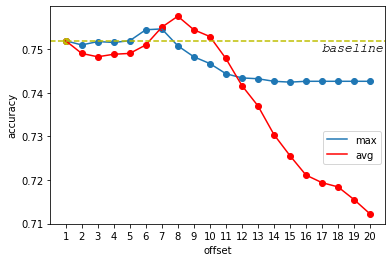

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Load a font
font_path = '/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf'
font_prop = fm.FontProperties(fname=font_path)

max_line = plt.plot(list(offset_to_accuracy_20_plus_1.keys()), list(offset_to_accuracy_20_plus_1.values()),label='max')
plt.xlabel('offset')
plt.ylabel('accuracy')
# the interval on x should be 1
plt.xticks(np.arange(min(list(offset_to_accuracy_20_plus_1.keys())), max(list(offset_to_accuracy_20_plus_1.keys()))+1, 1.0))
# add a dot at each point
plt.scatter(list(offset_to_accuracy_20_plus_1.keys()), list(offset_to_accuracy_20_plus_1.values()))

# draw the avg pooling
avg_line = plt.plot(list(offset_to_accuracy_avg_pooling_20_plus_1.keys()), list(offset_to_accuracy_avg_pooling_20_plus_1.values()), color='red', label='avg')
plt.scatter(list(offset_to_accuracy_avg_pooling_20_plus_1.keys()), list(offset_to_accuracy_avg_pooling_20_plus_1.values()), color='red')

# add a yellow horizontal line at y=offset_to_accuracy[0]
plt.axhline(y=offset_to_accuracy_avg_pooling_20_plus_1[1], color='y', linestyle='--')
# add the word "baseline" at the end of the yellow line in the font of calibri
plt.text(17, offset_to_accuracy_avg_pooling_20_plus_1[1] - 0.0025, 'baseline', fontproperties=font_prop, fontsize=13)
plt.scatter(1, offset_to_accuracy_avg_pooling_20_plus_1[1], color='y')

plt.legend(handles=[max_line[0], avg_line[0]], loc='upper center', bbox_to_anchor=(0.9, 0.45), ncol=1, fontsize=10)

plt.show()


In [ ]:
offset_to_accuracy

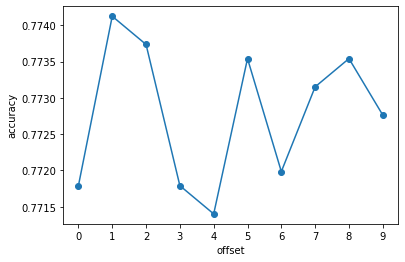

In [53]:
plt.plot(list(offset_to_accuracy_avg_pooling.keys()), list(offset_to_accuracy_avg_pooling.values()))
plt.xlabel('offset')
plt.ylabel('accuracy')
# the interval on x should be 1
plt.xticks(np.arange(min(list(offset_to_accuracy_avg_pooling.keys())), max(list(offset_to_accuracy_avg_pooling.keys()))+1, 1.0))
# add a dot at each point
plt.scatter(list(offset_to_accuracy_avg_pooling.keys()), list(offset_to_accuracy_avg_pooling.values()))
plt.show()

In [ ]:
offset_to_accuracy

In [23]:
import gc

del options_batch
del input_ids_batch
del outputs
gc.collect()

224

In [45]:
# empty the cache
torch.cuda.empty_cache()

In [18]:
import torch

# Get the current GPU memory allocation
allocated_memory_bytes = torch.cuda.memory_allocated(device=0)
# Convert the allocated memory to gigabytes
allocated_memory_gb = allocated_memory_bytes / (1024 ** 3)
print(f"Current GPU memory allocation: {allocated_memory_gb} GB")

Current GPU memory allocation: 12.651713848114014 GB


In [80]:
# empty the cache
torch.cuda.empty_cache()

In [36]:
'''Concatenate all options to get a huge tensor'''
all_options = []

tensor([32099,  8029,    15,    17,     3,     5], device='cuda:0')

In [40]:
options_batch = torch.nn.utils.rnn.pad_sequence(id_to_options[0] + id_to_options[1] , batch_first=True, padding_value=tokenizer.pad_token_id)
options_batch

tensor([[32099,  3957,     3,     5,     0,     0,     0],
        [32099,    24,     3,     5,     0,     0,     0],
        [32099,  3957,     3,     5,     0,     0,     0],
        [32099, 11831,     7,     3,     5,     0,     0],
        [32099,     3,     7,  2618,    15,     3,     5],
        [32099,  2049,     3,     5,     0,     0,     0],
        [32099,   278,     3,    31,     0,     0,     0],
        [32099,     3,     7,  2618,    15,     3,     6],
        [32099,     3,     7,  2618,    15,     3,    55]], device='cuda:0')

In [27]:
input_string = data_appended[0]['inputs_pretokenized']
input_ids = tokenizer(input_string, return_tensors="pt").input_ids.to(device)
id_to_options[0]

[tensor([32099,  3957,     3,     5], device='cuda:0'),
 tensor([32099,    24,     3,     5], device='cuda:0'),
 tensor([32099,  3957,     3,     5], device='cuda:0'),
 tensor([32099, 11831,     7,     3,     5], device='cuda:0')]

In [47]:
total_no_options = 0
no_options_list = []
for id in id_to_options:
    total_no_options += len(id_to_options[id])
    no_options_list.append(len(id_to_options[id]))
# avg
total_no_options/len(id_to_options)

12.290122258878323

In [24]:
'''test to make sure that padding and concatenating individual examaples doesn't mess up results'''

# options is below
# [tensor([32099,  3957,     3,     5], device='cuda:0'),
#  tensor([32099,    24,     3,     5], device='cuda:0'),
#  tensor([32099,  3957,     3,     5], device='cuda:0'),
#  tensor([32099, 11831,     7,     3,     5], device='cuda:0')]

#convert to options_batch by padding to the max length
options_batch = torch.nn.utils.rnn.pad_sequence(id_to_options[0], batch_first=True, padding_value=tokenizer.pad_token_id)
# options_batch
# create a number of input_ids same to the number of elements in ids_to_options[0]
input_ids_batch = torch.cat([input_ids for i in range(len(id_to_options[0]))], dim=0)

outputs = model(input_ids_batch, labels=options_batch)
# outputs = model(input_ids_batch[1].unsqueeze(0), labels=options_batch[1].unsqueeze(0))
# outputs.loss

In [28]:
options_batch_1 = id_to_options[0][1].unsqueeze(0)
input_ids_batch_1 = input_ids
outputs_1 = model(input_ids_batch_1, labels=options_batch_1)

In [44]:
outputs.logits[1][:-1] == outputs_1.logits[0]
print(outputs.logits[1][:-1])
print(outputs_1.logits[0])
print(options_batch_1)

loss0 = loss_fn(outputs.logits[1][:-1], options_batch_1[0])
loss0_padded = loss_fn(outputs.logits[1], options_batch[1])
loss0_1 = loss_fn(outputs_1.logits[0], options_batch_1[0])
print(loss0)
print(loss0_padded)
print(loss0_1)

tensor([[-18.2500, -20.6250, -19.7500,  ..., -46.5000, -48.5000, -46.7500],
        [-21.3750, -14.9375, -11.7500,  ..., -47.0000, -49.2500, -48.0000],
        [-18.8750, -14.7500,  -8.5000,  ..., -47.2500, -49.5000, -48.2500],
        [-24.0000, -14.8750,  -4.2812,  ..., -54.2500, -57.0000, -55.2500]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SliceBackward0>)
tensor([[-18.3750, -20.6250, -19.7500,  ..., -46.5000, -48.7500, -47.0000],
        [-21.2500, -14.9375, -11.7500,  ..., -47.0000, -49.2500, -48.0000],
        [-18.8750, -14.6875,  -8.3750,  ..., -47.0000, -49.2500, -48.0000],
        [-23.7500, -14.8125,  -4.2188,  ..., -54.0000, -56.7500, -55.0000]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)
tensor([[32099,    24,     3,     5]], device='cuda:0')
tensor(0.8242, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<NllLossBackward0>)
tensor(0.8242, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<NllLossBackward0>)
tensor(0.82

In [34]:
options

[tensor([32099, 17162,     3,     5], device='cuda:0'),
 tensor([32099,  1907,    51,     9,     3,     5], device='cuda:0'),
 tensor([32099,   103,     3,    29,    31], device='cuda:0'),
 tensor([32099, 17162,     3,     6], device='cuda:0'),
 tensor([32099,   470,     3,     5], device='cuda:0'),
 tensor([32099, 17162,     3,     6], device='cuda:0'),
 tensor([32099,  1907,    51,     9,     3,     6], device='cuda:0'),
 tensor([32099, 17162,     3,     6], device='cuda:0'),
 tensor([32099,   103,     3,    29,    31], device='cuda:0'),
 tensor([32099, 17162,     3,     5], device='cuda:0'),
 tensor([32099, 17162,     3,     5], device='cuda:0')]

In [64]:
id_to_options[0]

[tensor([32099,  3957,     3,     5], device='cuda:0'),
 tensor([32099,    24,     3,     5], device='cuda:0'),
 tensor([32099,  3957,     3,     5], device='cuda:0'),
 tensor([32099, 11831,     7,     3,     5], device='cuda:0')]

In [32]:
print(outputs.logits[1].shape)
print(outputs_1.logits[0].shape)

torch.Size([5, 32128])
torch.Size([4, 32128])


In [59]:
# loss_fn(outputs.logits, options_batch)
logits_0 = outputs.logits[1]
options_batch_0 = options_batch[1]
# logits_0.shape

loss = loss_fn(logits_0, options_batch_0)
loss

tensor(4.3438, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<NllLossBackward0>)

In [113]:
outputs['scores']
for i in range(len(outputs['scores'])):
    probs_outputs_beam_scores = torch.nn.functional.softmax(outputs['scores'][i], dim=-1)
    print(probs_outputs_beam_scores[0])
    # argmax 
    print(torch.argmax(probs_outputs_beam_scores[0]))
    # decode it
    # print(tokenizer.decode(torch.argmax(probs_outputs_beam_scores[0])))
    # the value
    print(probs_outputs_beam_scores[0][torch.argmax(probs_outputs_beam_scores[0])])

tensor([1.3621e-08, 1.1132e-09, 3.0414e-09,  ..., 7.3057e-21, 9.9262e-22,
        5.6910e-21], device='cuda:0', dtype=torch.bfloat16)
tensor(32099, device='cuda:0')
tensor(1., device='cuda:0', dtype=torch.bfloat16)
tensor([4.6202e-10, 2.5518e-07, 6.1691e-06,  ..., 3.0308e-21, 3.1929e-22,
        1.1117e-21], device='cuda:0', dtype=torch.bfloat16)
tensor(8, device='cuda:0')
tensor(0.1855, device='cuda:0', dtype=torch.bfloat16)
tensor([9.3860e-10, 1.2442e-06, 3.0160e-05,  ..., 2.4458e-20, 3.3087e-21,
        8.9997e-21], device='cuda:0', dtype=torch.bfloat16)
tensor(11831, device='cuda:0')
tensor(0.2373, device='cuda:0', dtype=torch.bfloat16)
tensor([7.8944e-10, 3.6135e-07, 1.1349e-04,  ..., 1.1581e-21, 1.2160e-22,
        4.2352e-22], device='cuda:0', dtype=torch.bfloat16)
tensor(3, device='cuda:0')
tensor(0.5703, device='cuda:0', dtype=torch.bfloat16)
tensor([8.4128e-11, 3.8743e-07, 4.8340e-02,  ..., 1.6647e-23, 1.0663e-24,
        4.7821e-24], device='cuda:0', dtype=torch.bfloat16)
te

In [53]:
input_string = data_appended[0]['inputs_pretokenized']
inputs = tokenizer(input_string, return_tensors="pt").input_ids.to(device)
num_beams = 2
outputs = model.generate(inputs, 
                        # max_length=8, 
                        num_beams=num_beams, 
                        num_return_sequences=num_beams,
                        # eos_token_id=tokenizer.convert_tokens_to_ids('<extra_id_1>'),
                        return_dict_in_generate=True,
                        output_scores=True)

/home1/09127/tomyoung/.local/lib/python3.9/site-packages/transformers/generation_utils.py:1296: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [54]:
outputs['sequences_scores'][0]

tensor(-0.6948, device='cuda:0')

In [52]:
tokenizer.decode(outputs['sequences'][0])

'<pad><extra_id_0> signs anymore. i'

In [50]:
# decode the ids in outputs['sequences'][0] one by one
decoded = []
for id in outputs['sequences'][0]:
    decoded.append(tokenizer.decode(id))
decoded

['<pad>', '<extra_id_0>', 'signs', 'anymore', '', '.', '', 'i']

In [113]:
input_ids = tokenizer(data_appended[0]['inputs_pretokenized'], return_tensors="pt").input_ids.to(device)
print(data_appended[0]['inputs_pretokenized'])
labels = tokenizer("<extra_id_0> " + id_to_word_and_punc_pairs_processed[0][2] + " <extra_id_1>", return_tensors="pt").input_ids.to(device)
print("<extra_id_0> " + id_to_word_and_punc_pairs_processed[0][2] + " <extra_id_1>")
outputs = model(input_ids, labels=labels)
loss = outputs.loss
logits = outputs.logits
# logits

[NLU] in my palm is a clear stone , and inside it is a small ivory statuette . a guardian angel . `` figured if you 're going to be out at night getting hit by cars , you might as well have some backup . '' i look at him , feeling stunned . like this is some sort of sign . but as i stare at harlin , his mouth curved in a confident grin , i do n't care about <extra_id_0>
<extra_id_0> signs. <extra_id_1>


tensor([[[-18.6250, -20.8750, -19.6250,  ..., -46.5000, -48.5000, -46.7500],
         [-21.5000, -14.5625, -12.0625,  ..., -47.0000, -49.2500, -47.7500],
         [-20.3750, -15.2500, -10.1250,  ..., -50.7500, -53.2500, -52.0000],
         [-16.8750, -11.0625,  -6.5000,  ..., -42.2500, -44.7500, -43.7500],
         [-18.6250, -14.0000,  -4.1562,  ..., -41.5000, -43.7500, -43.0000]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [68]:
# calculate loss with cross entropy loss function
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
loss

tensor(1.0312, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<NllLossBackward0>)

In [1]:
input_string = "[NLG] A man is having a bun for <extra_id_0>"
inputs = tokenizer(input_string, return_tensors="pt").input_ids.to(device)
num_beams = 1
# outputs = model.generate(inputs, num_beams=num_beams, max_length=3, num_return_sequences=num_beams, output_scores=True, return_dict_in_generate=True)
outputs = model.generate(inputs, max_length=3, output_scores=True, return_dict_in_generate=True)
# outputs = model.generate(inputs, output_scores=True, return_dict_in_generate=True)

for i in range(num_beams):
    # print(outputs['sequences'][i])
    print(tokenizer.decode(outputs['sequences'][i]))
    # decode outputs['sequences'][i] one by one token
    print('-------------')
    # print(outputs['sequences_scores'][i])

NameError: name 'tokenizer' is not defined

In [7]:
# /work/09127/tomyoung/ls6/data/pkls/url_to_probs_c4_dict_with_labels_t5_11b_valid.pkl
import pickle
with open('/work/09127/tomyoung/ls6/data/pkls/url_to_probs_c4_dict_with_labels_t5_11b_valid.pkl', 'rb') as f:
    url_to_probs_c4_dict_with_labels_t5_11b_valid = pickle.load(f)

In [6]:
# '/work/09127/tomyoung/ls6/data/pkls/acceptable_alternatives_1000_ignore_cws_nos_50_valid.pkl'
with open('/work/09127/tomyoung/ls6/data/pkls/acceptable_alternatives_1000_ignore_cws_nos_50_valid.pkl', 'rb') as f:
    acceptable_alternatives_1000_ignore_cws_nos_50_valid = pickle.load(f)

In [8]:
c4_json_file = '/work/09127/tomyoung/ls6/data/jsons/c4-validation.00000-of-00001-list-of-lists.json'
import json
with open(c4_json_file, 'r', encoding='utf8') as f:
    dicts_realnewslike = json.load(f)

In [5]:
from transformers import T5Tokenizer, BartTokenizer
t5_tokenizer = T5Tokenizer.from_pretrained('t5-3b')
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

/home1/09127/tomyoung/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-3b automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [53]:
'''based on url_to_probs_c4_dict_with_labels_t5_11b_valid and acceptable_alternatives_1000_ignore_cws_nos_50_valid
generate the input string and target string for the models like ul2 and glm'''
proposed_bigram = t5_tokenizer.decode(url_to_probs_c4_dict_with_labels_t5_11b_valid[((0,17,4),(0,17,5),1)]['proposed bigram'])

acceptable_alternatives_1000_ignore_cws_nos_50_valid[(0,17,4)][0][1]

proposed_bigram = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[(0,17,4)][0][1][4+1:4+3])
print('proposed_bigram:', proposed_bigram)

preceding_tokens = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[(0,17,4)][0][1][:4])
print('preceding_tokens:', preceding_tokens)

following_tokens = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[(0,17,4)][0][1][4+3:])
print('following_tokens:', following_tokens)


proposed_bigram:  upgrade package
preceding_tokens: <s>Also included in
following_tokens:  is a new Linux Cluster Install Tool, which automates much of the installation work, IBM officials said.</s>


In [10]:
url_to_probs_c4_dict_with_labels_t5_11b_valid_keys = list(url_to_probs_c4_dict_with_labels_t5_11b_valid.keys())

url_to_ul2_probs_dict = {}
import math
for i in tqdm(range(len(url_to_probs_c4_dict_with_labels_t5_11b_valid_keys))):#len(url_to_probs_c4_dict_with_labels_t5_11b_valid_keys)
    key = url_to_probs_c4_dict_with_labels_t5_11b_valid_keys[i]
    url_to_ul2_probs_dict[url_to_probs_c4_dict_with_labels_t5_11b_valid_keys[i]] = {}
    show(key)
    show(key[0])
    show(acceptable_alternatives_1000_ignore_cws_nos_50_valid[key[0]])
    # acceptable_alternatives_1000_ignore_cws_nos_50_valid
    # process the proposed bigram and token
    url = key[0]
    story_id = key[0][0]
    paragraph_id = key[0][1]
    option_id = key[2]
    proposed_token_pos = key[0][2]

    ''' proposed token '''
    # acceptable_alternatives_1000_ignore_cws_nos_50_valid has an <s> </s>
    proposed_token = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[url][0][option_id][proposed_token_pos+1:proposed_token_pos+2])
    preceding_tokens_to_proposed_token = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[url][0][option_id][:proposed_token_pos+1])
    following_tokens_to_proposed_token = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[url][0][option_id][proposed_token_pos+2:])
    show('proposed_token:', proposed_token)
    show('preceding_tokens_to_proposed_token:', preceding_tokens_to_proposed_token)
    show('following_tokens_to_proposed_token:', following_tokens_to_proposed_token)
    # generate the input string by adding a <extra_id_0> in the middle of the sentence
    input_string = preceding_tokens_to_proposed_token + ' <extra_id_0>' + following_tokens_to_proposed_token
    # remove <s> and </s> in the input string
    input_string = input_string.replace('<s>', '')
    input_string = input_string.replace('</s>', '')
    # add [NLU] to the input string
    input_string = '[NLU] ' + input_string
    show('input_string:', input_string)
    target_string = '<extra_id_0>' + proposed_token + ' <extra_id_1>'
    show('target_string_proposed_token:', target_string)
    inputs = tokenizer(input_string, return_tensors="pt").input_ids.to(device)
    labels = tokenizer(target_string, return_tensors="pt").input_ids.to(device)
    show('labels_proposed_token:', labels)
    # remove the last </s> token from labels
    labels = labels[:, :-1].contiguous()
    show('inputs:', inputs)
    show('labels:', labels)
    outputs = model(inputs, labels=labels)
    # print('outputs:', outputs)
    log_p = -loss_fn_sum(outputs.logits[0][1:], labels[0][1:]) # [1:] to remove the first token <extra_id_0>
    show('log_p_proposed_token:', log_p)
    example_raw_sequence = dicts_realnewslike[story_id][paragraph_id]
    show('example_raw_sequence:', example_raw_sequence)
    # tokenize the raw sequence
    example_raw_sequence_bart_tokenized = bart_tokenizer.tokenize(example_raw_sequence)
    bart_ids_original = bart_tokenizer.convert_tokens_to_ids(example_raw_sequence_bart_tokenized)
    
    ''' original token '''
    original_token = bart_tokenizer.decode(bart_ids_original[proposed_token_pos])
    show('original_token:', original_token)
    target_string_original_token = '<extra_id_0>' + original_token + ' <extra_id_1>'
    show('target_string_original_token:', target_string_original_token)
    labels_original_token = tokenizer(target_string_original_token, return_tensors="pt").input_ids.to(device)
    labels_original_token = labels_original_token[:, :-1].contiguous()
    show('labels_original_token:', labels_original_token)
    outputs = model(inputs, labels=labels_original_token)
    log_p_original_token = -loss_fn_sum(outputs.logits[0][1:], labels_original_token[0][1:]) # [1:] to remove the first token <extra_id_0>
    show('log_p_original_token:', log_p_original_token)
    
    
    ''' proposed bigram '''
    constant_token_pos = key[1][2]
    proposed_token_is_to_the_left = proposed_token_pos < constant_token_pos
    if proposed_token_is_to_the_left:
        proposed_bigram = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[url][0][option_id][proposed_token_pos+1:proposed_token_pos+3])
        preceding_tokens_to_proposed_bigram = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[url][0][option_id][:proposed_token_pos+1])
        following_tokens_to_proposed_bigram = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[url][0][option_id][proposed_token_pos+3:])
        original_bigram = bart_tokenizer.decode(bart_ids_original[proposed_token_pos:proposed_token_pos+2])
    else:
        proposed_bigram = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[url][0][option_id][proposed_token_pos:proposed_token_pos+2])
        preceding_tokens_to_proposed_bigram = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[url][0][option_id][:proposed_token_pos])
        following_tokens_to_proposed_bigram = bart_tokenizer.decode(acceptable_alternatives_1000_ignore_cws_nos_50_valid[url][0][option_id][proposed_token_pos+2:])
        original_bigram = bart_tokenizer.decode(bart_ids_original[proposed_token_pos-1:proposed_token_pos+1])
    show('proposed_bigram:', proposed_bigram)
    show('preceding_tokens_to_proposed_bigram:', preceding_tokens_to_proposed_bigram)
    show('following_tokens_to_proposed_bigram:', following_tokens_to_proposed_bigram)
    show('original_bigram:', original_bigram)
    
    
    # generate the input string by adding a <extra_id_0> in the middle of the sentence
    input_string = preceding_tokens_to_proposed_bigram + ' <extra_id_0>' + following_tokens_to_proposed_bigram
    # remove <s> and </s> in the input string
    input_string = input_string.replace('<s>', '')
    input_string = input_string.replace('</s>', '')
    # add [NLU] to the input string
    input_string = '[NLU] ' + input_string
    show('input_string:', input_string)
    target_string = '<extra_id_0>' + proposed_bigram + ' <extra_id_1>'
    show('target_string:', target_string)
    inputs = tokenizer(input_string, return_tensors="pt").input_ids.to(device)
    labels = tokenizer(target_string, return_tensors="pt").input_ids.to(device)
    # remove the last </s> token from labels
    labels = labels[:, :-1].contiguous()
    show('inputs:', inputs)
    show('labels:', labels)
    outputs = model(inputs, labels=labels)
    # print('outputs:', outputs)
    log_p_proposed_bigram = -loss_fn_sum(outputs.logits[0][1:], labels[0][1:]) #
    show('log_p_proposed_bigram:', log_p_proposed_bigram)


    '''original bigram'''
    target_string_original_bigram = '<extra_id_0>' + original_bigram + ' <extra_id_1>'
    show('target_string_original_bigram:', target_string_original_bigram)
    labels_original_bigram = tokenizer(target_string_original_bigram, return_tensors="pt").input_ids.to(device)
    labels_original_bigram = labels_original_bigram[:, :-1].contiguous()
    outputs = model(inputs, labels=labels_original_bigram)
    # print('outputs:', outputs)
    log_p_original_bigram = -loss_fn_sum(outputs.logits[0][1:], labels_original_bigram[0][1:]) #
    show('log_p_original_bigram:', log_p_original_bigram)
    # put the log_p's into the dictionary
    url_to_ul2_probs_dict[key] = {'proposed token': math.exp(log_p.to(torch.float32).detach().cpu().numpy()),
                                'original token': math.exp(log_p_original_token.to(torch.float32).detach().cpu().numpy()),
                                'proposed bigram': math.exp(log_p_proposed_bigram.to(torch.float32).detach().cpu().numpy()),
                                'original bigram': math.exp(log_p_original_bigram.to(torch.float32).detach().cpu().numpy())}
url_to_ul2_probs_dict_filepath = '/work/09127/tomyoung/ls6/data/pkls/url_to_ul2_probs_dict_valid.pkl'
with open(url_to_ul2_probs_dict_filepath, 'wb') as f:
    pickle.dump(url_to_ul2_probs_dict, f)


100%|██████████| 22152/22152 [1:55:33<00:00,  3.20it/s]  


: 

In [ ]:
url_to_ul2_probs_dict_filepath = '/work/09127/tomyoung/ls6/data/pkls/url_to_ul2_probs_dict_valid.pkl'
with open(url_to_ul2_probs_dict_filepath, 'wb') as f:
    pickle.dump(url_to_ul2_probs_dict, f)


In [ ]:
# /work/09127/tomyoung/ls6/data/pkls/url_to_probs_c4_dict_with_labels_t5_11b_valid.pkl
import pickle
with open('/work/09127/tomyoung/ls6/data/pkls/url_to_probs_c4_dict_with_labels_t5_11b_valid.pkl', 'rb') as f:
    url_to_probs_c4_dict_with_labels_t5_11b_valid = pickle.load(f)

In [ ]:
url_to_probs_c4_dict_with_labels_t5_11b_valid[((0,17,4),(0,17,5),1)]